In [1]:
import pymc as pm
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr
az.style.use("arviz-white")
%matplotlib inline

In [2]:
def visualise_kernel(cov, *, x0=0, x1=2, k=200, ax=None, size=1, method="plot", **kwargs):
    cov = cov + pm.gp.cov.WhiteNoise(1e-6)
    X = np.linspace(x0, x1, k)[:, None]
    K = cov(X).eval()
    if ax is None:
        ax = plt.gca()
    getattr(ax, method)(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=size).eval().T, **kwargs)

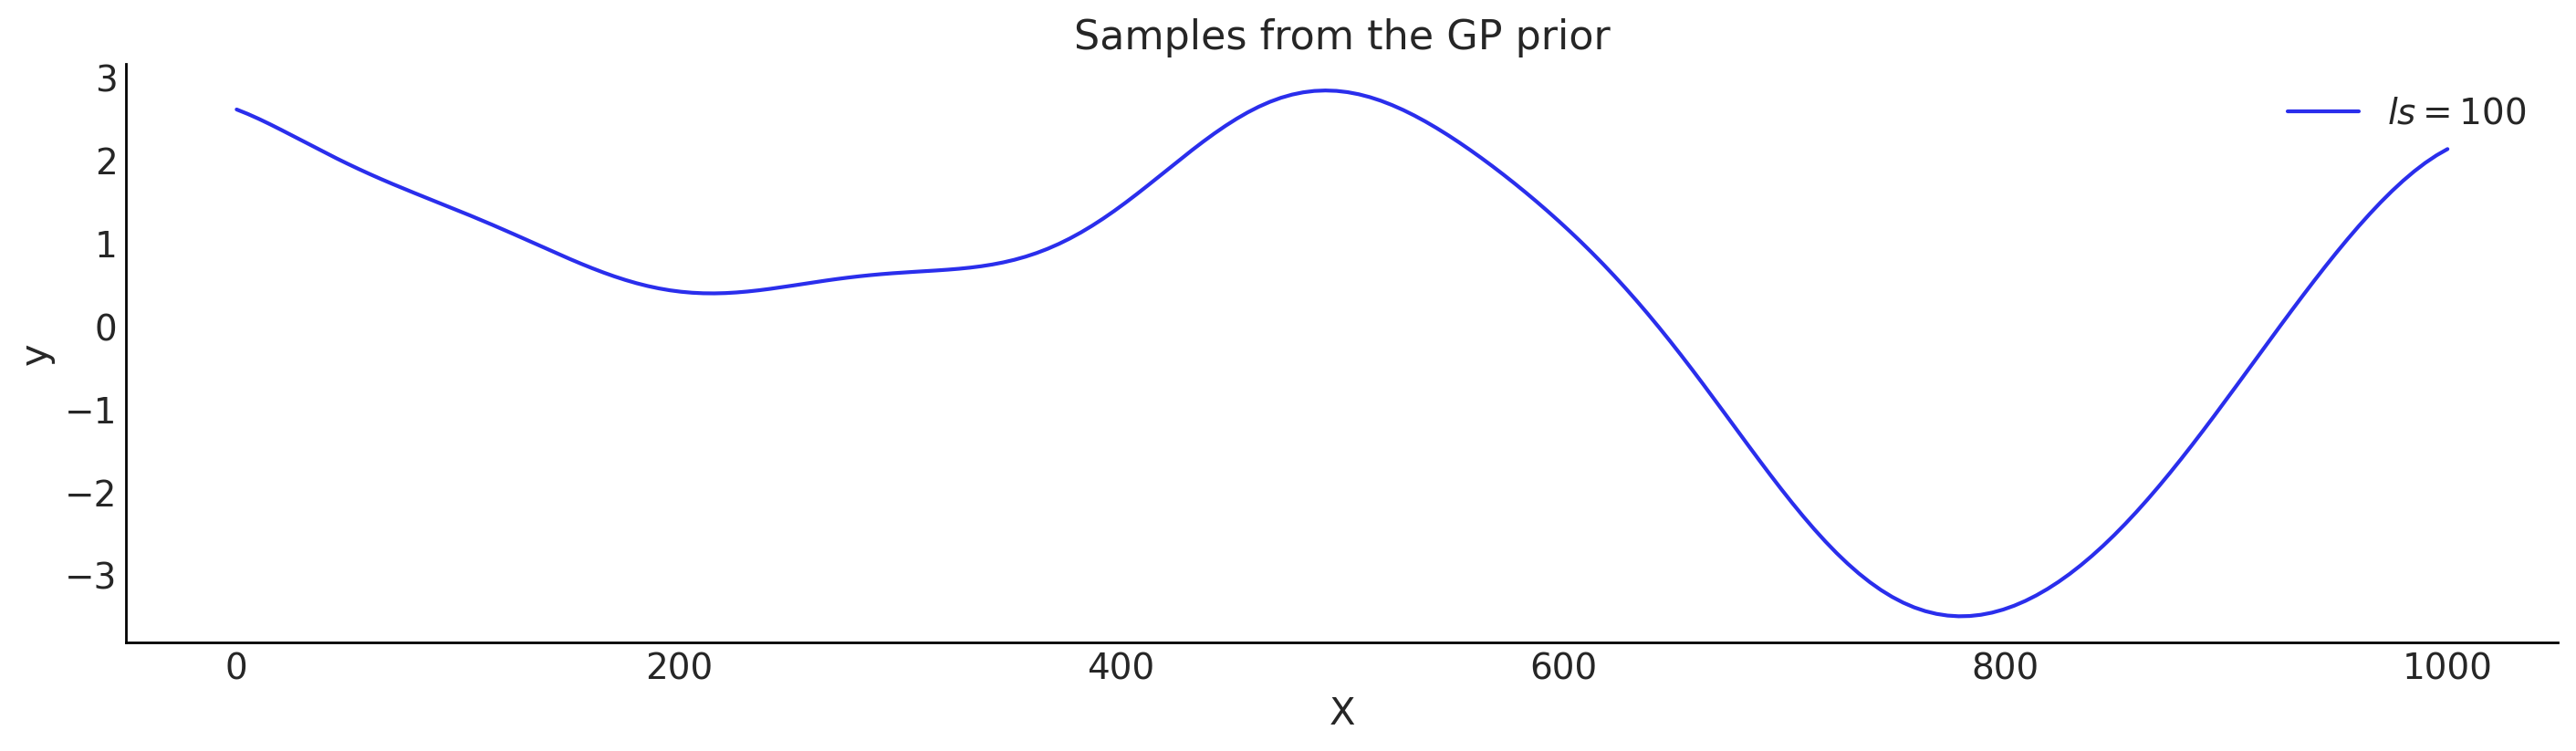

In [3]:
lengthscales = [100]
plt.figure(figsize=(14, 4))
for i, l in enumerate(lengthscales):
    eta = 2.0
    cov = eta**2 * pm.gp.cov.ExpQuad(1, l)
    # Add white noise to stabilise
    visualise_kernel(cov, x0=0, x1=1000, color=f"C{i}", label=fr"$ls={l}$")


plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");
plt.legend();

K * sd**2

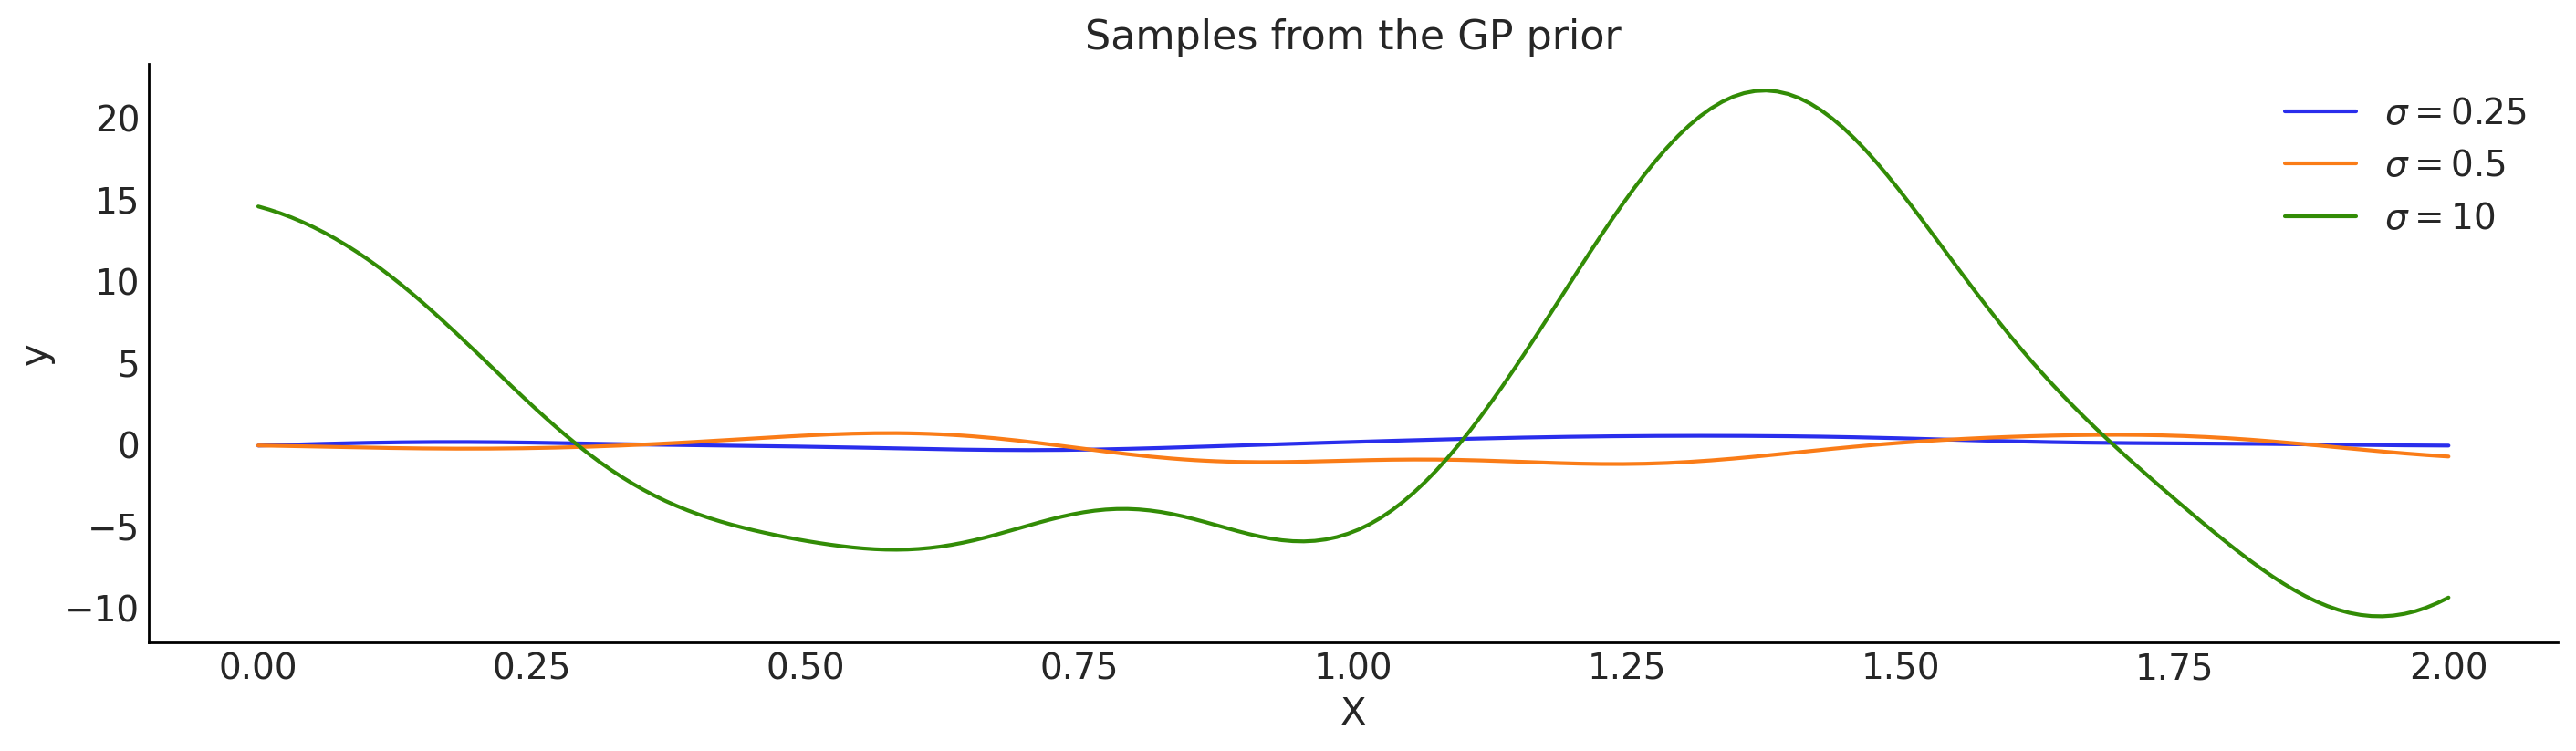

In [4]:
amplitudes = [0.25, 0.5, 10]
plt.figure(figsize=(14, 4))
for i, am in enumerate(amplitudes):
    cov = am**2 * pm.gp.cov.ExpQuad(1, 0.2)
    # Add white noise to stabilise
    visualise_kernel(cov, color=f"C{i}", label=fr"$\sigma={am}$")
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");
plt.legend()

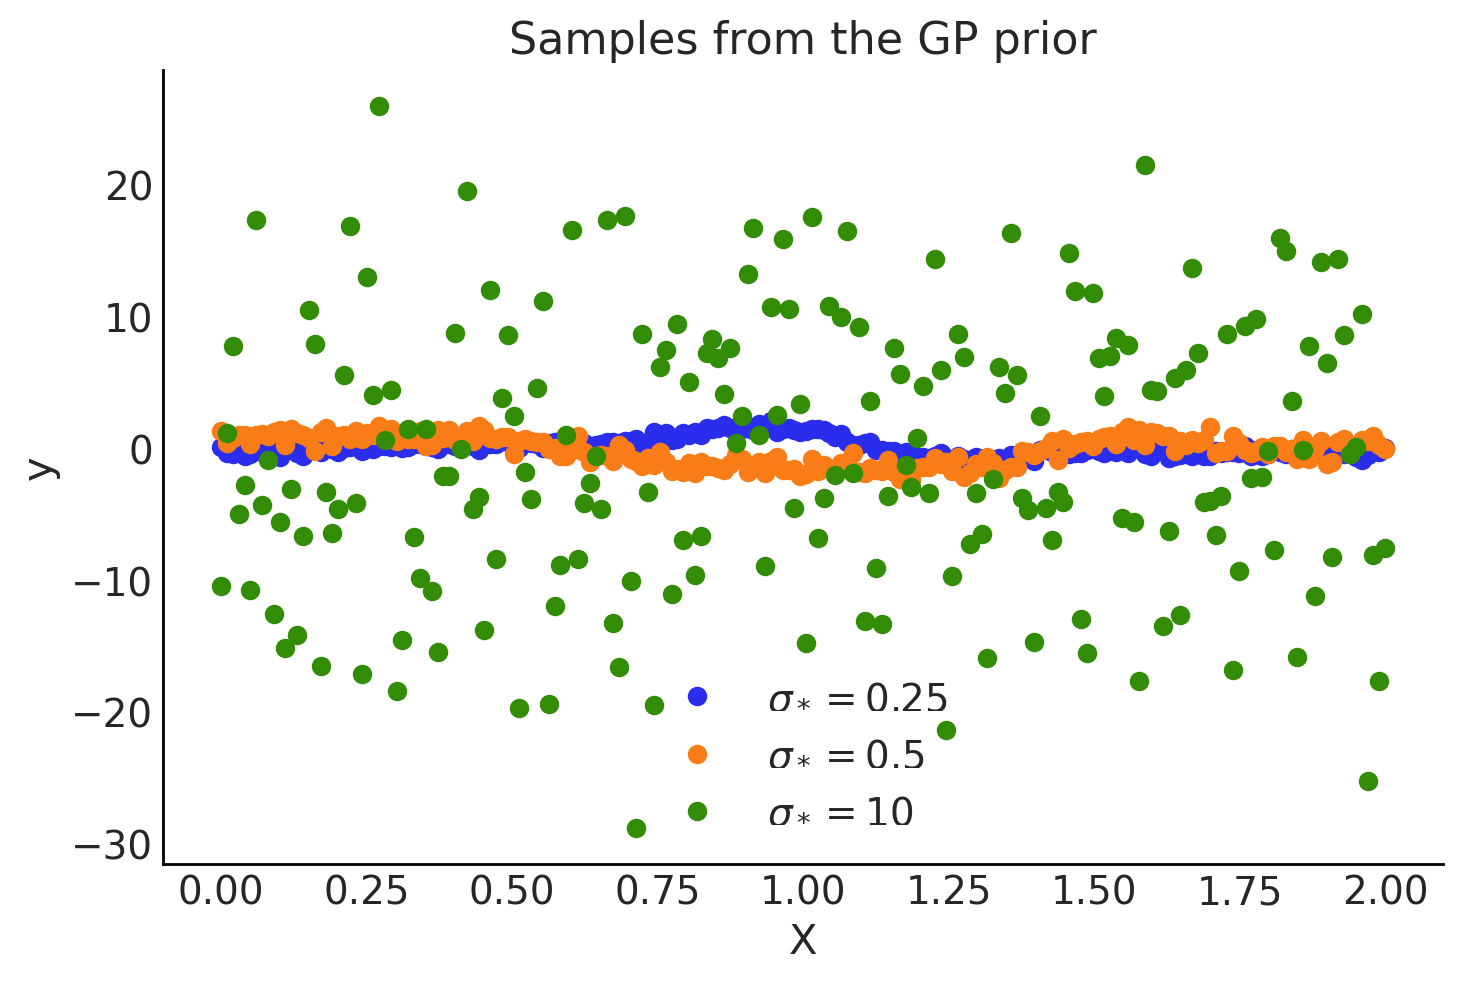

In [5]:
white_noise = [0.25, 0.5, 10]

for i, noi in enumerate(white_noise):
    cov = pm.gp.cov.ExpQuad(1, 0.2) + pm.gp.cov.WhiteNoise(noi)
    visualise_kernel(cov, color=f"C{i}", label=fr"$\sigma_*={noi}$", method="scatter")
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");
plt.legend()

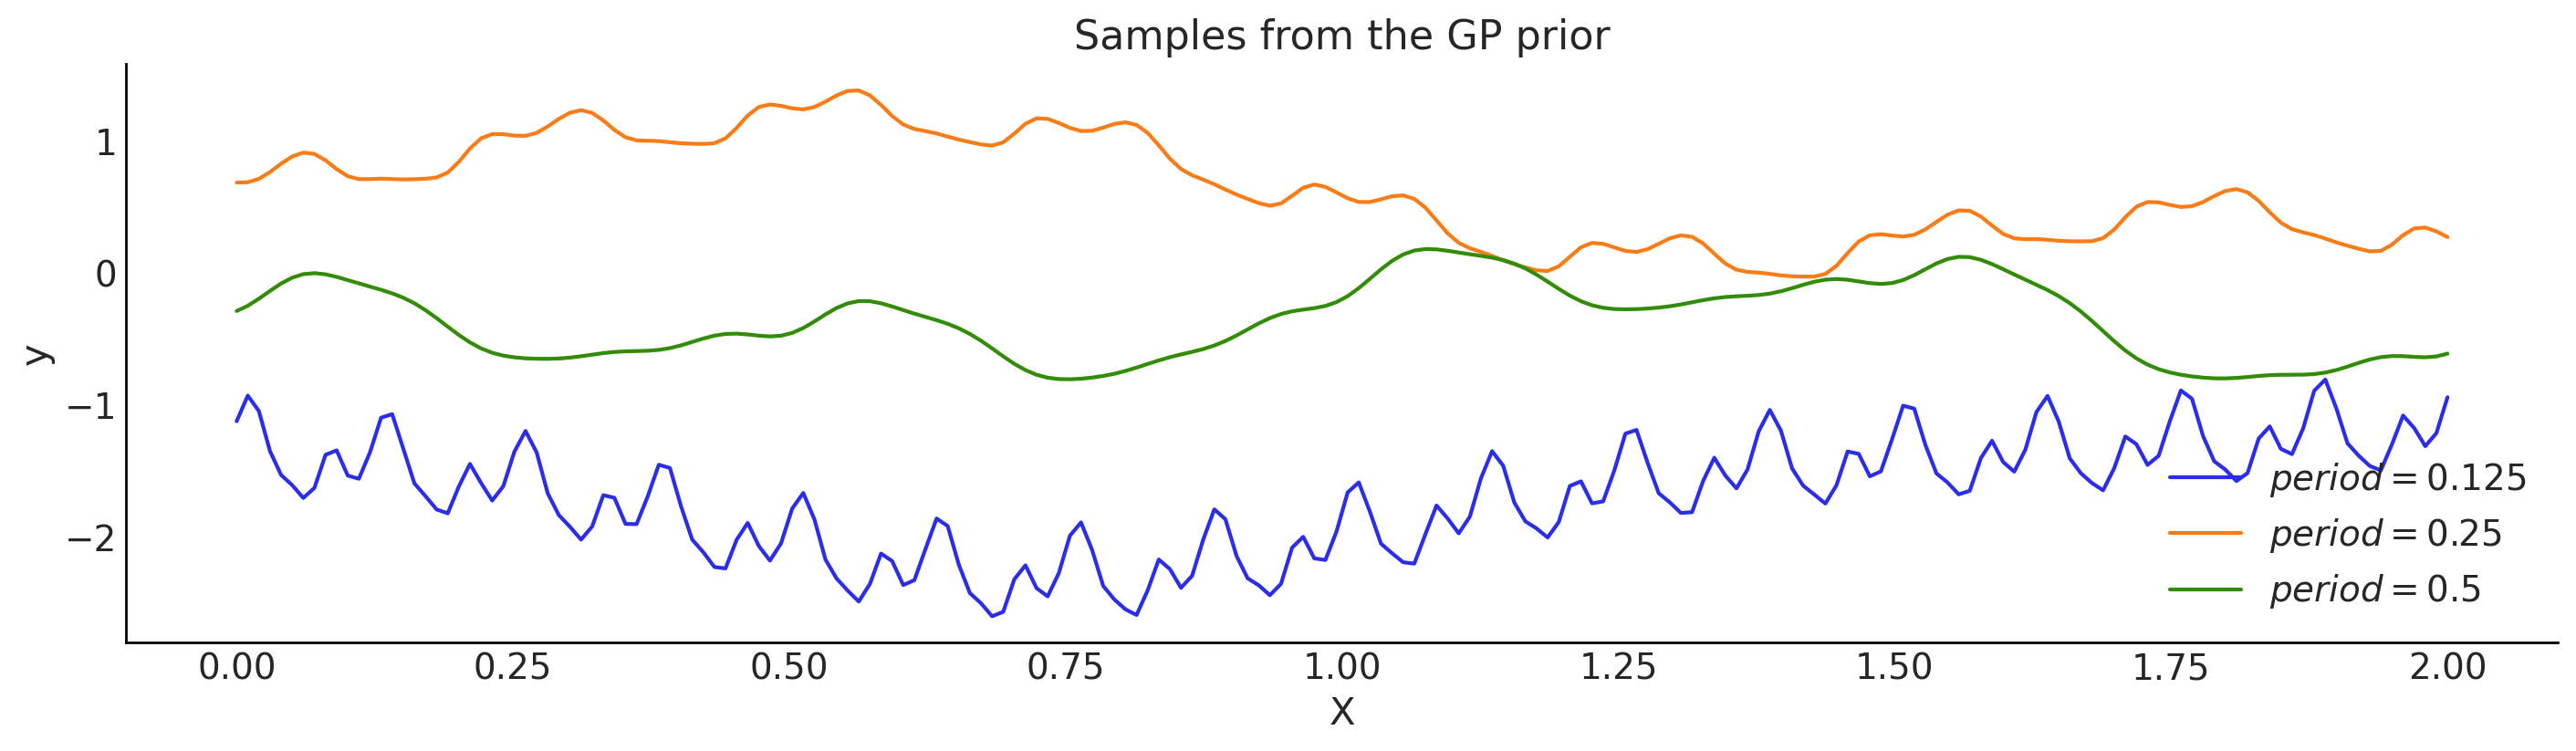

In [6]:
periods = [0.125, 0.25, 0.5]
plt.figure(figsize=(14, 4))
for i, period in enumerate(periods):
    var = 3
    w = 0.8
    cov = pm.gp.cov.ExpQuad(1, ls=0.5) * (w) + pm.gp.cov.Periodic(1, period=period, ls=0.5)*(1-w)
    # Add white noise to stabilise
    visualise_kernel(cov, color=f"C{i}", label=fr"$period={period}$")
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");
plt.legend()

(0.0, 0.3333333333333333)

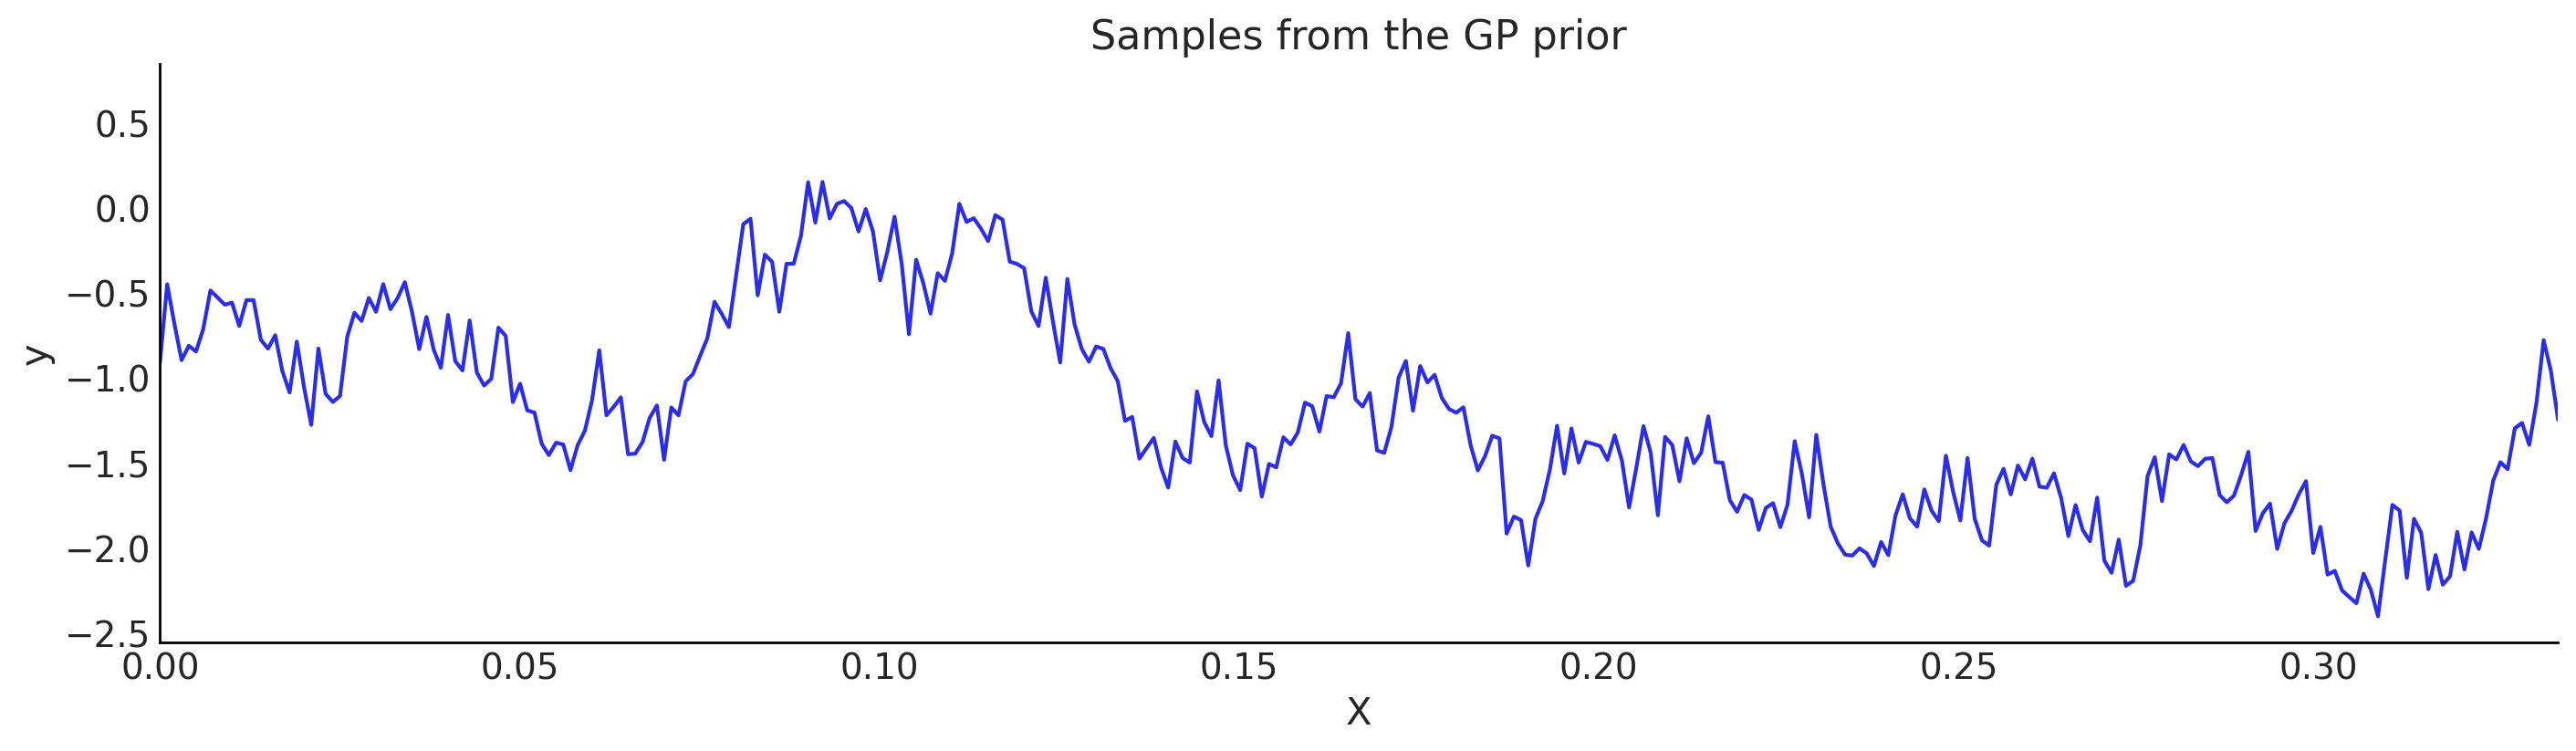

In [7]:
periods = [1, 0.25, 1/12, 1/12/4]
lengthscales = [1, 0.25, 1/12*2, 1/12/4*2]
weights = [0.7, 0.2, 0.08, 0.02]
plt.figure(figsize=(14, 4))
cov = sum(
    [pm.gp.cov.Periodic(1, period=p, ls=ls) * w for p, ls, w in zip(periods, lengthscales, weights)]
)
# Add white noise to stabilise
visualise_kernel(cov, x1=1, k=1000, size=1)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");
plt.xlim(0, 4/12)

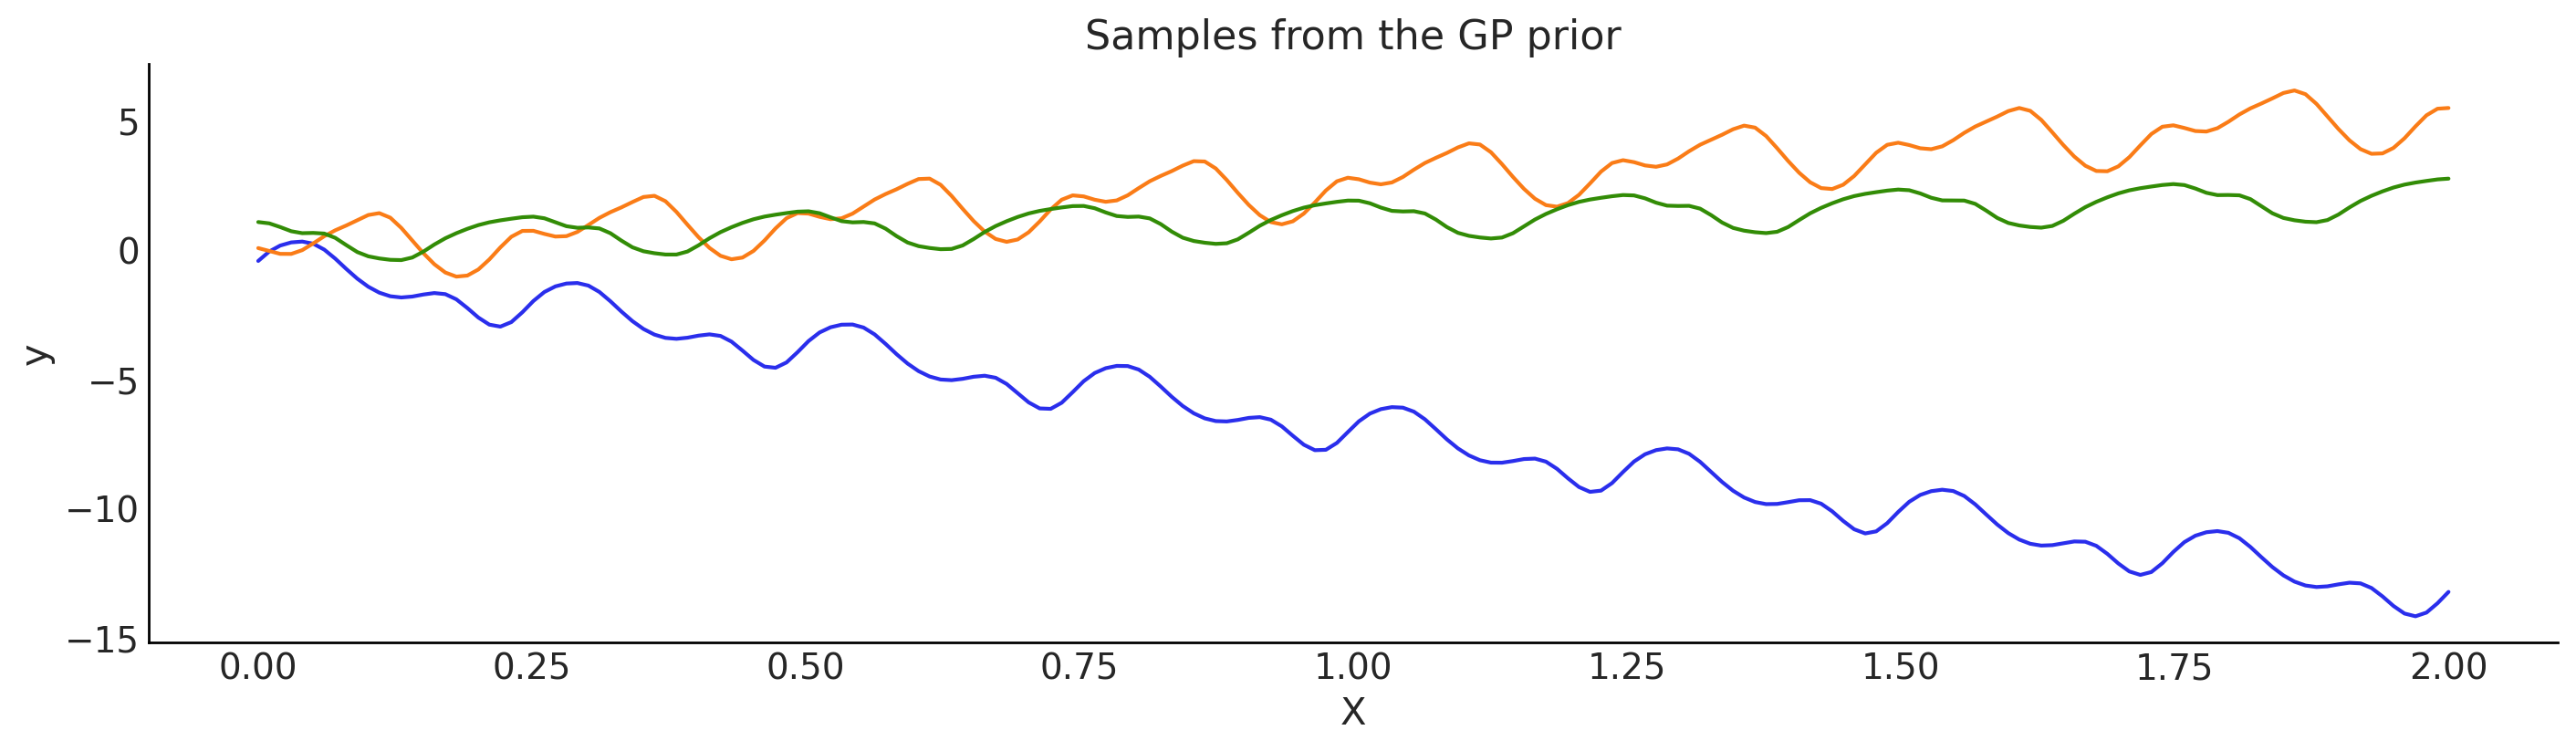

In [8]:
plt.figure(figsize=(14, 4))
cov = pm.gp.cov.Linear(1, c=0) * 10 + pm.gp.cov.Periodic(1, period=0.25, ls=0.5)
# Add white noise to stabilise
visualise_kernel(cov, size=3)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

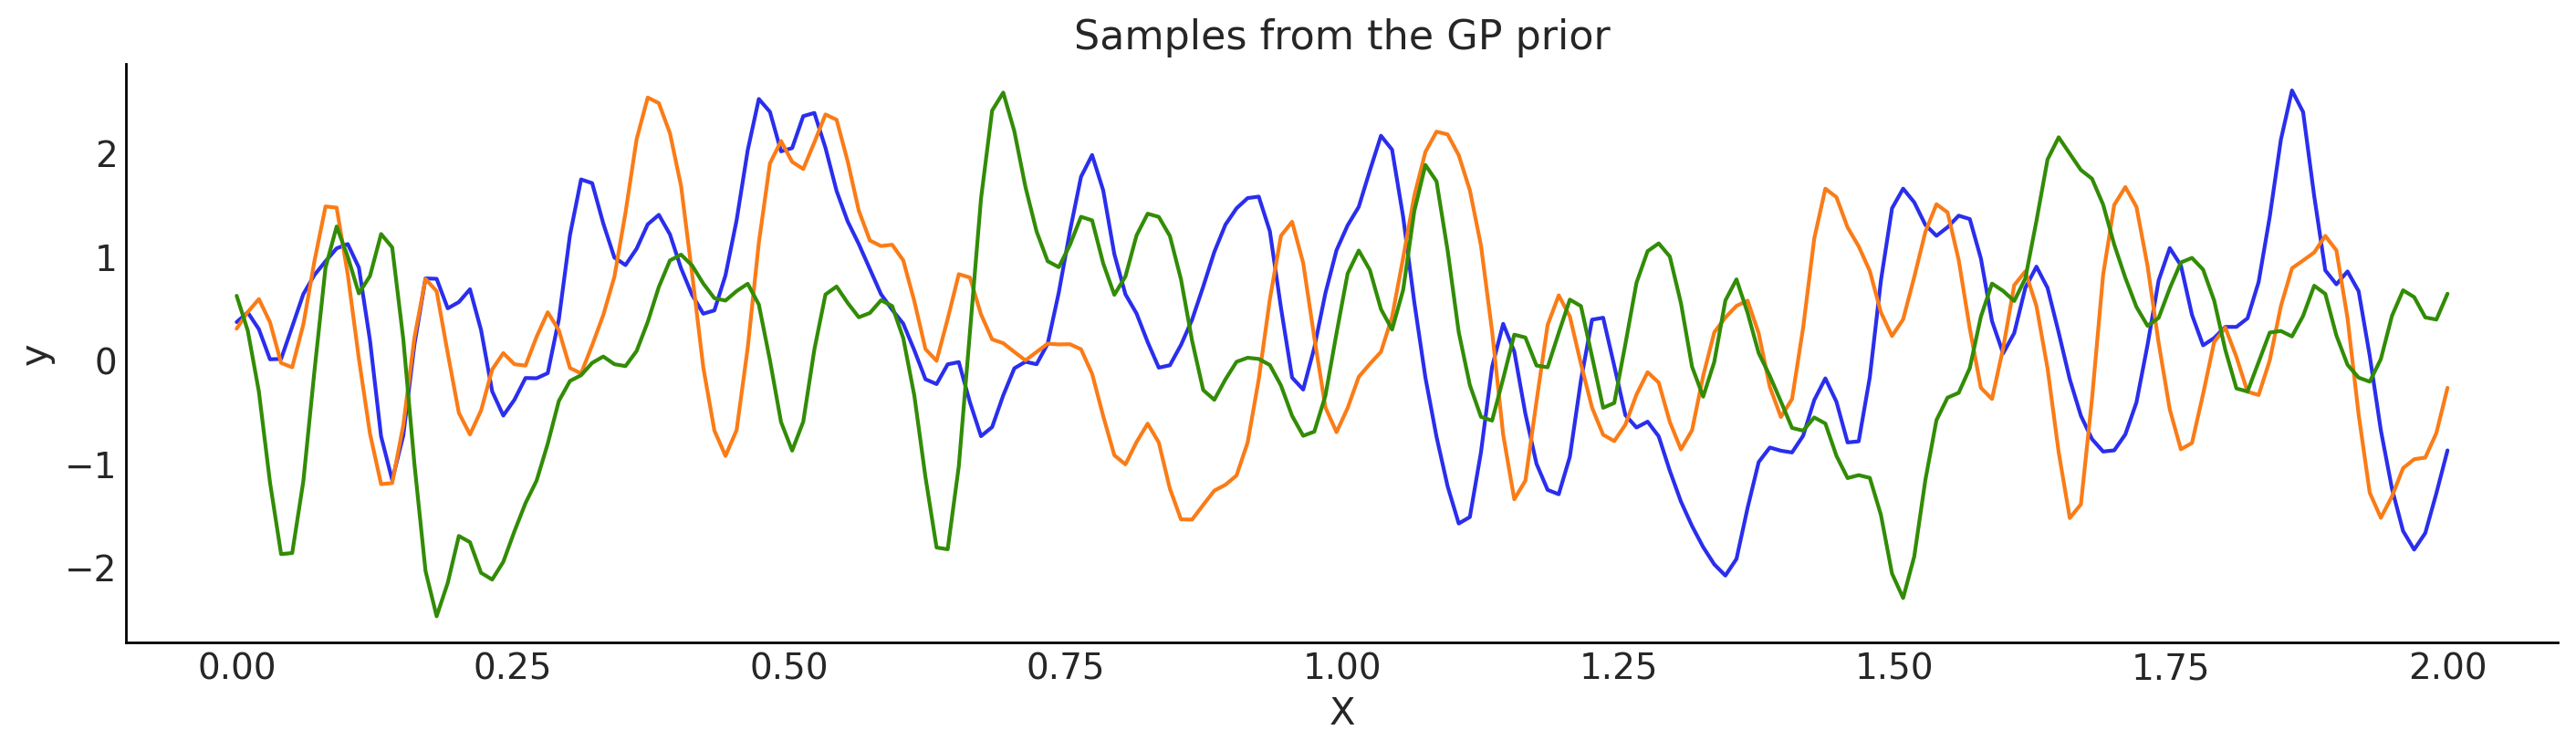

In [9]:
plt.figure(figsize=(14, 4))
cov = pm.gp.cov.ExpQuad(1, ls=0.1) * pm.gp.cov.Periodic(1, period=0.25, ls=0.3)
# Add white noise to stabilise
visualise_kernel(cov, size=3)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

In [10]:
J = 8
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
# lower std for better visualizations
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18]) / 2

In [ ]:
with pm.Model(coords=dict(J=range(J))) as schools_centered:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sigma=tau, dims="J")
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    trace0 = pm.sample()

In [255]:
with pm.Model(coords=dict(J=range(J))) as schools_noncentered:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, dims="J")
    theta = pm.Deterministic("theta", mu + tau * theta_tilde, dims="J")
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    trace1 = pm.sample(target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, tau, theta_t]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

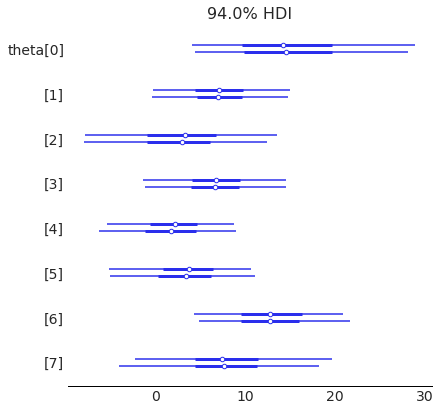

In [190]:
az.plot_forest(trace1, var_names=["theta"])

In [247]:
school_coords = np.array(
    [[  0.,  10.],
     [  8., -11.],
     [  0.,  -4.],
     [ -1.,  -3.],
     [ 16.,   4.],
     [ 17.,  19.],
     [  7., 5.],
     [ 5.,  -7.]])

gridxy = np.mgrid[
    school_coords[:, 0].min()-1:school_coords[:, 0].max()+1:20j,
    school_coords[:, 1].min()-1:school_coords[:, 1].max()+1:20j
]
grid = gridxy.reshape(2, -1).T

In [196]:
trace1.posterior.theta.mean(["chain", "draw"]).values

array([15.21041805,  7.10668458,  2.58232263,  6.62654122,  1.80201072,
        3.29486264, 12.99941911,  8.03649302])

Text(0.5, 1.0, 'Schools coordinates')

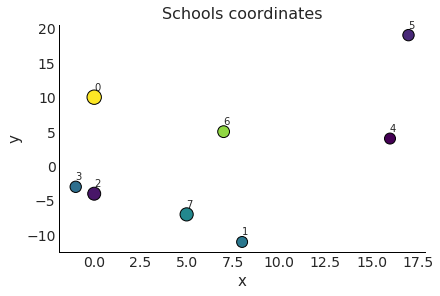

In [201]:
y = trace1.posterior.theta.mean(["chain", "draw"]).values
s = trace1.posterior.theta.std(["chain", "draw"]).values
plt.scatter(*school_coords.T, c=(y-min(y))/(max(y)-min(y)), s=s*30, edgecolors="black")
[plt.text(x, y+1, str(i)) for i, (x, y) in enumerate(school_coords)];
plt.xlabel("x")
plt.ylabel("y")
plt.title("Schools coordinates")

Text(0.5, 1.0, 'Schools coordinates')

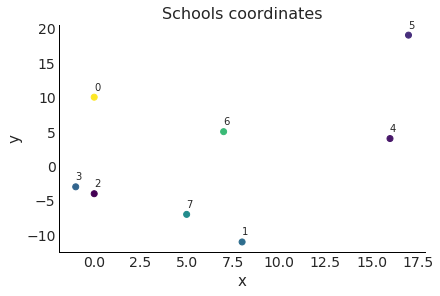

In [192]:
plt.scatter(*school_coords.T, c=(y-min(y))/(max(y)-min(y)))
[plt.text(x, y+1, str(i)) for i, (x, y) in enumerate(school_coords)];
plt.xlabel("x")
plt.ylabel("y")
plt.title("Schools coordinates")

In [242]:
X = np.random.randn(100, 2)
Y = np.sin(X[:, 0]*5)*4 + (X[:, 1]) ** 2 + np.random.randn(100) *0.01

Text(0.5, 1.0, 'Schools coordinates')

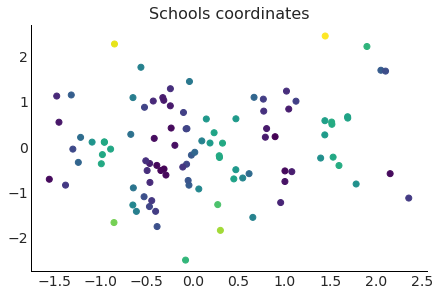

In [243]:
plt.scatter(*X.T, c=(Y-min(Y))/(max(Y)-min(Y)))
plt.title("Schools coordinates")

In [244]:
with pm.Model() as gp_visual:
    ls = pm.Gamma("ls", mu=1, sigma=0.3)
    magnitude = pm.Exponential("magnitude", 1)

    cov = pm.gp.cov.ExpQuad(2, ls=ls) * magnitude
    
    white_noise = pm.Exponential("white_noise", 50)
    mean = pm.Normal("mean", 0, 1)
    
    
    gp = pm.gp.Marginal(mean_func=pm.gp.mean.Constant(mean), cov_func=cov)
    
    
    gp.marginal_likelihood("lik", X, Y, sigma=white_noise)

In [210]:
with gp_visual:
    prior = pm.sample_prior_predictive()

Sampling: [lik, ls, magnitude, mean, white_noise]


In [211]:
prior.prior_predictive.lik.mean()

<xarray.DataArray 'lik' (chain: 1, draw: 500, lik_dim_0: 10)>
array([[[ 1.31037927,  1.23943536,  1.27222605, ...,  1.28311486,
          1.17959093,  1.22843546],
        [-0.25062352, -0.34330097, -0.24946285, ..., -0.37497328,
         -0.52235505, -0.40067498],
        [-0.52190671, -0.49607924, -0.53871305, ..., -0.44673016,
         -0.472845  , -0.53135614],
        ...,
        [-2.40573552, -2.15301702, -2.09775663, ..., -2.23018233,
         -2.62674641, -2.35549805],
        [-0.3150437 , -0.10612806, -0.12633278, ..., -0.20152914,
         -0.2752435 , -0.14156037],
        [-0.3960101 , -0.41462957, -0.70537616, ..., -0.41006794,
         -0.06400083, -0.29100176]]])
Coordinates:
  * chain      (chain) int64 0
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * lik_dim_0  (lik_dim_0) int64 0 1 2 3 4 5 6 7 8 9

Text(0.5, 1.0, 'Schools coordinates')

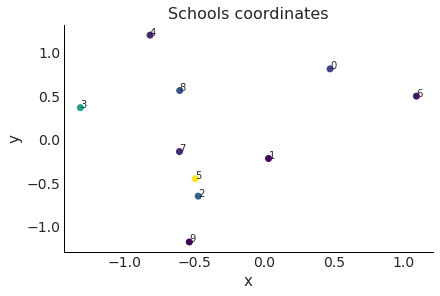

In [216]:
y = prior.prior_predictive.lik.mean(["draw", "chain"])
prior.prior_predictive.lik.std(["draw", "chain"])
plt.scatter(*X.T, c=(y-min(y))/(max(y)-min(y)))
[plt.text(x, y, str(i)) for i, (x, y) in enumerate(X)];
plt.xlabel("x")
plt.ylabel("y")
plt.title("Schools coordinates")

In [241]:
import nutpie

/usr/local/lib/python3.9/dist-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mean'}>,
        <AxesSubplot:title={'center':'mean'}>],
       [<AxesSubplot:title={'center':'ls'}>,
        <AxesSubplot:title={'center':'ls'}>],
       [<AxesSubplot:title={'center':'magnitude'}>,
        <AxesSubplot:title={'center':'magnitude'}>],
       [<AxesSubplot:title={'center':'white_noise'}>,
        <AxesSubplot:title={'center':'white_noise'}>]], dtype=object)

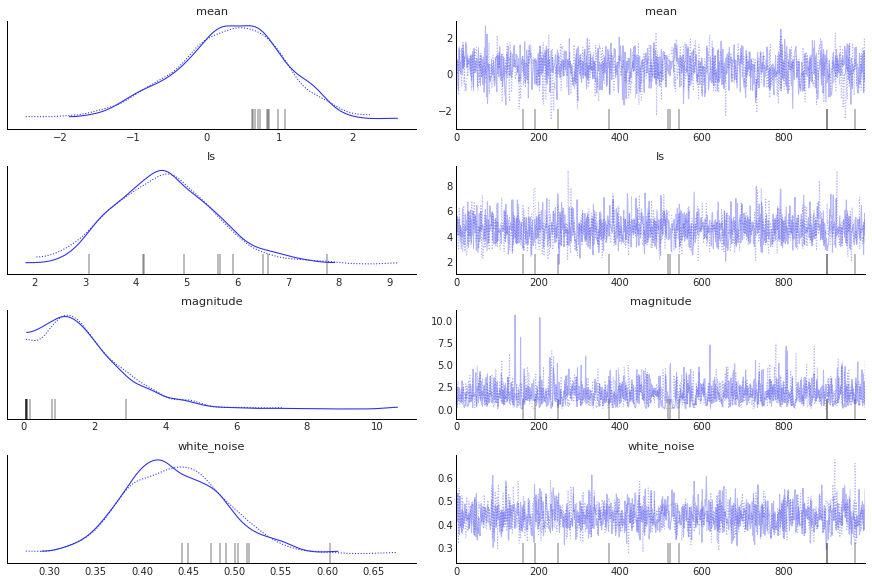

In [219]:
az.plot_trace(trace)

In [248]:
with pm.Model() as gp_visual:
    ls = pm.Gamma("ls", mu=5, sigma=1)
    cov = pm.gp.cov.ExpQuad(2, ls=ls)
    gp = pm.gp.Latent(cov_func=cov)
    theta = gp.prior("theta_grid", grid)
    trace = pm.sample_prior_predictive(4, var_names=["theta_grid"])

Sampling: [ls, theta_grid_rotated_]


In [203]:
trace.prior.theta_grid.values.squeeze()

array([[ 2.22291633,  2.00986649,  1.76871097, ...,  0.1383708 ,
         0.29312039,  0.44967893],
       [-0.07561613, -0.34591411, -0.44448388, ...,  0.06165307,
         0.37513611,  0.59522839],
       [ 0.68729032,  1.18741463,  1.22751471, ..., -0.5875707 ,
        -0.22859976, -0.1345462 ],
       [-1.09913693, -0.74238145, -0.32839739, ..., -1.2679033 ,
        -0.90767919, -0.58352448]])

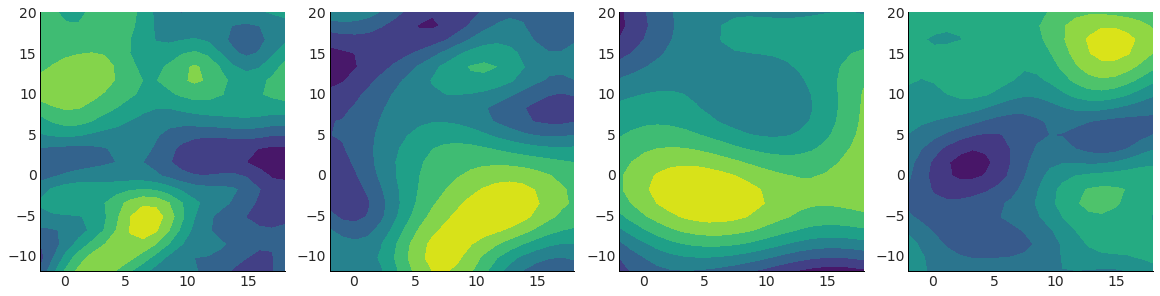

In [249]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, draw in enumerate(trace.prior.theta_grid.values.squeeze()):
    gridz = draw.reshape(20, 20)
    axes[i].contourf(*gridxy, gridz)

In [253]:
with pm.Model(coords=dict(J=range(J))) as schools_gp:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    
    # before
    # theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, dims="J")
    # after
    ls = pm.Gamma("ls", mu=5, sigma=1)
    cov = pm.gp.cov.ExpQuad(2, ls=ls)
    gp = pm.gp.Latent(cov_func=cov)
    theta_tilde = gp.prior("theta_t", school_coords, dims="J")
    
    theta = pm.Deterministic("theta", mu + tau * theta_tilde, dims="J")
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    trace2 = pm.sample(target_accept=0.90)
    
    # extrapolation
    theta_tilde_grid = gp.conditional("theta_t_grid", grid)
    theta_grid = pm.Deterministic("theta_grid", mu + tau * theta_tilde_grid)
    trace2.extend(pm.sample_posterior_predictive(trace2.sel(draw=np.s_[::100]), var_names=["theta_grid"]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, tau, ls, theta_t_rotated_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
Sampling: [theta_t_grid]


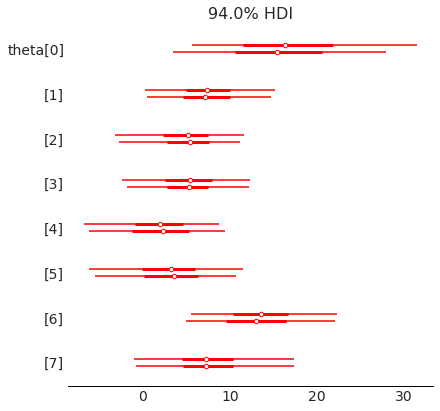

In [262]:
ax = az.plot_forest(trace2, var_names=["theta"], colors="red")

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

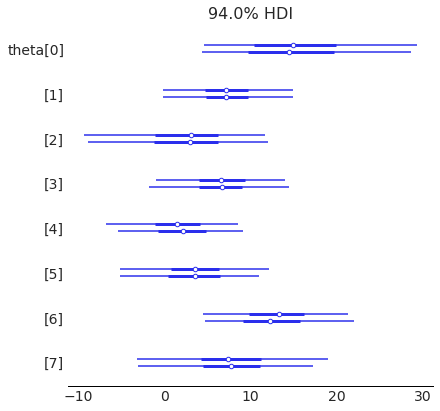

In [263]:
az.plot_forest(trace1, var_names=["theta"])

In [ ]:
gridxy.shape

In [264]:
gridz = trace2.posterior_predictive["theta_grid"].mean(["chain", "draw"]).values.reshape(20, 20)

Text(0, 0.5, 'y')

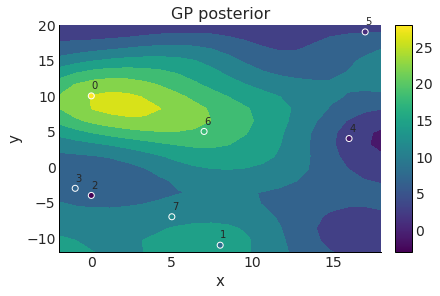

In [265]:
plt.contourf(*gridxy, gridz)
plt.scatter(*school_coords.T, c=y, edgecolors="w")
[plt.text(x, y+1, str(i)) for i, (x, y) in enumerate(school_coords)];
plt.colorbar();
plt.title("GP posterior")
plt.xlabel("x")
plt.ylabel("y")

In [266]:
X = np.random.randn(100, 2)
Y = np.sin(X[:, 0]*5)*4 + (X[:, 1]) ** 2 + np.random.randn(100) *0.01

NameError: name 'np' is not defined